<a href="https://colab.research.google.com/github/georgesolis/portafolio/blob/main/Campa%C3%B1a_Mkt_Mailing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Caso N°1 - Campaña de Marketing**


---

Una empresa "X" tiene presupuestado una campaña de marketing en donde desean enviar correos masivos a una base de clientes, sin embargo para mejorar la conversión y optimizar el presupuesto, se busca priorizar a los clientes que tenga mayor probabilidad de conversión mediante mail. Se cuenta con una base de datos histórica en donde se indica que clientes abrieron el mail y que clientes no abrieron el mail.

El proyecto necesita que, mediante el uso de analìtica de datos y machine learning, perfilemos el grupo de clientes que tenga mayor probabilidad de abrir el correo. 


---

*   Población objetivo: Clientes que abrieron el mail.
*   Unidad de análisis: Cliente

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import types
import matplotlib.mlab as mlab
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler
import pandas.core.algorithms as algos
from pandas import Series
import scipy.stats.stats as stats
import re
import traceback
import string
import os
from sklearn.model_selection import train_test_split
from pycaret.classification import *
import sweetviz
import seaborn as sns
import time 
from datetime import date
from datetime import timedelta

In [3]:
# Cargamos el dataset
data = pd.read_csv('campana-Marketing.csv')
data.head()

,CLIENTE,EDAD,ANIOS_AFILIACION,ESTADO_CIVIL,SEXO,CPM,TP,TXTS,MEDIO_PAGO,TARGET
0,1,62,3,C,M,405,27,15,Efectivo,0
1,2,60,8,C,F,387,85,5,tc,1
2,3,59,7,C,F,366,44,8,tc,1
3,4,47,8,S,M,244,244,1,Efectivo,0
4,5,44,8,S,F,629,173,4,tc,1


**Análisis exploratorio de datos**

In [4]:
eda_obj= sweetviz.analyze(data)

eda_obj.show_html('EDA_CAMPANA_MKT' + '.html', layout='widescreen', scale = 0.8)

                                             |          | [  0%]   00:00 -> (? left)

Report EDA_CAMPANA_MKT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [5]:
data.columns.values

array(['CLIENTE', 'EDAD', 'ANIOS_AFILIACION', 'ESTADO_CIVIL', 'SEXO',
       'CPM', 'TP', 'TXTS', 'MEDIO_PAGO', 'TARGET'], dtype=object)

In [6]:
cat = data[['ESTADO_CIVIL','SEXO','MEDIO_PAGO']]

In [7]:
cat.describe(include='all').transpose()

,count,unique,top,freq
ESTADO_CIVIL,500,4,C,292
SEXO,500,2,F,292
MEDIO_PAGO,500,3,tc,258


In [8]:
num = data[['EDAD', 'ANIOS_AFILIACION','CPM', 'TP', 'TXTS']]
num.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
EDAD,500.0,50.442,14.436046,18.0,39.0,49.0,61.00,90.0
ANIOS_AFILIACION,500.0,5.248,2.450818,0.0,3.0,6.0,7.00,8.0
CPM,500.0,368.688,306.928730,11.0,177.0,275.5,471.25,2879.0
TP,500.0,82.864,68.653070,6.0,37.0,63.0,105.00,459.0
TXTS,500.0,6.286,5.990658,1.0,3.0,4.0,8.00,54.0


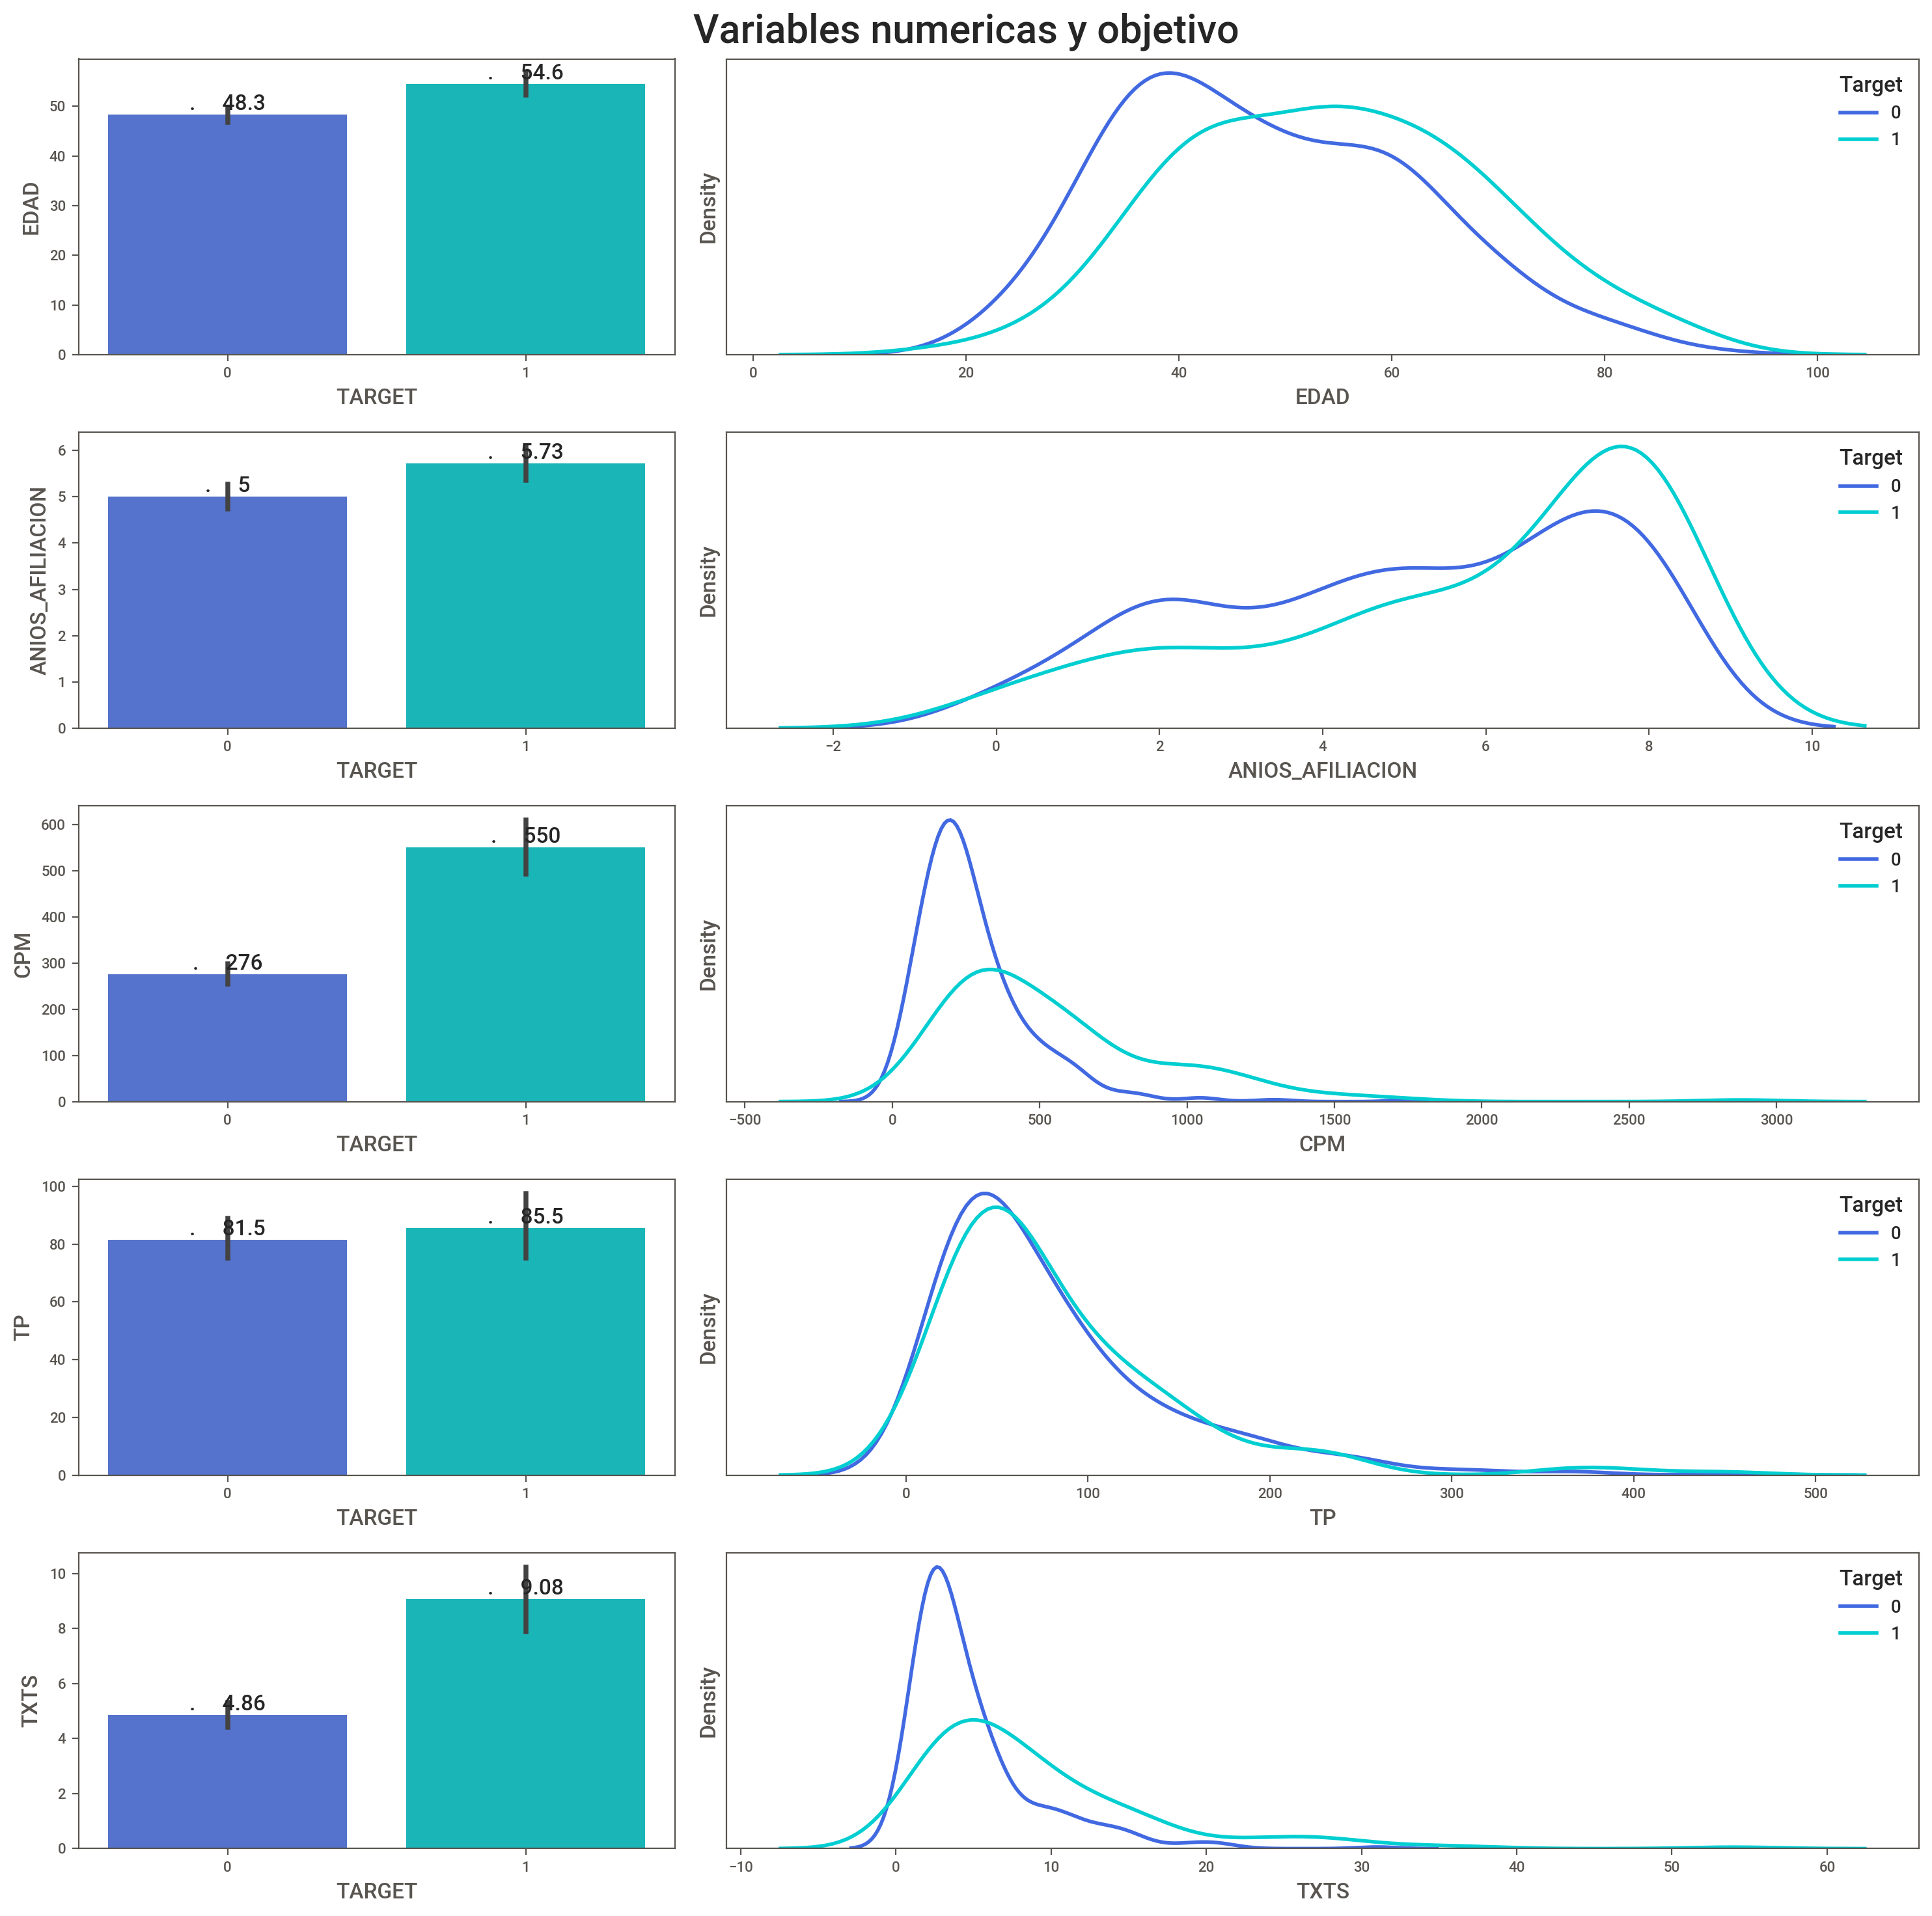

In [9]:
objetivo = 'TARGET'
Num_Features = ['EDAD', 'ANIOS_AFILIACION','CPM', 'TP', 'TXTS']

sns.set_palette(['royalblue','darkturquoise'])
fig, ax = plt.subplots(5,2,figsize=(15,15),dpi=200,gridspec_kw={'width_ratios': [1,2]})
for i,col in enumerate(Num_Features):
    #barplot
    graph = sns.barplot(data=data,x=objetivo, y=col, ax=ax[i,0])
    #kde PLOT
    sns.kdeplot(data=data[data[objetivo]==0],x=col, linewidth=2, ax=ax[i,1],label='0')
    sns.kdeplot(data=data[data[objetivo]==1],x=col, linewidth=2, ax=ax[i,1],label='1')
    ax[i,1].set_yticks([])
    ax[i,1].legend(title="Target",loc='upper right')
    #add bar sizes to our plot
    for cont in graph.containers:
      graph.bar_label(cont, fmt='.     %.3g')

plt.suptitle('Variables numericas y objetivo', fontsize=22)
plt.tight_layout()
plt.show()

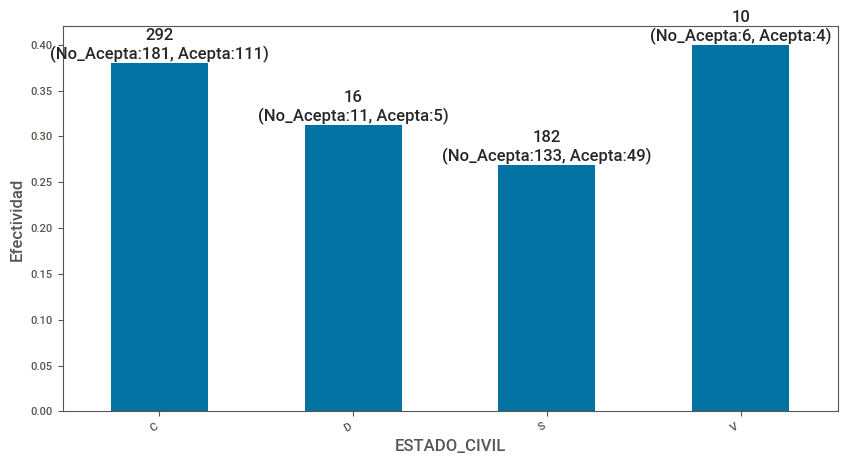

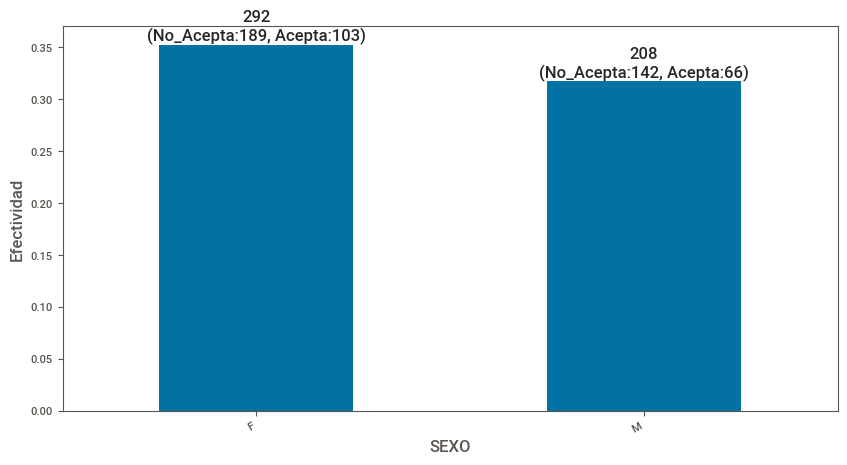

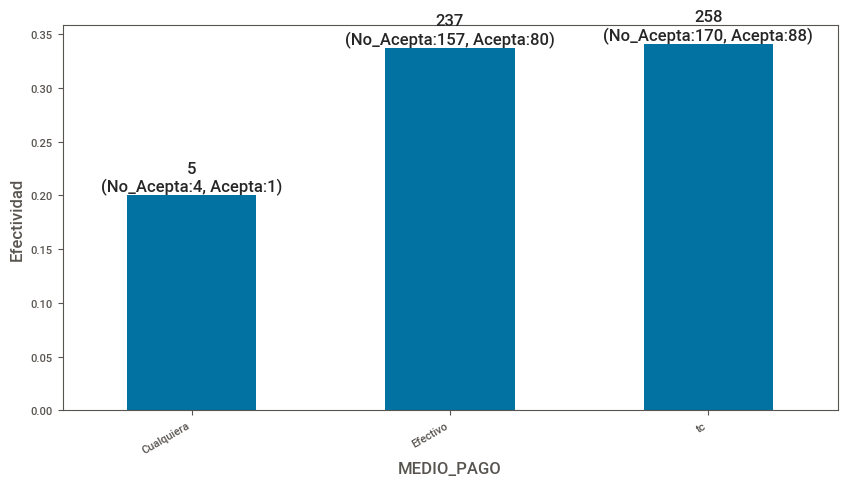

In [10]:
cat_features = ['ESTADO_CIVIL','SEXO','MEDIO_PAGO']
for i in cat_features:
    resumen = pd.concat([data[data.TARGET == 0].groupby(i).TARGET.count()
                          , data[data.TARGET == 1].groupby(i).TARGET.count()], axis=1)
    resumen.columns = ['No_Acepta','Acepta']
    resumen_f = resumen.Acepta / (resumen.Acepta + resumen.No_Acepta)
    plt.figure(figsize=(10,5))
    ax = resumen_f.plot(kind='bar', color='b')
    ax.set_xticklabels(resumen_f.index, rotation=30, fontsize=8, ha='right')
    ax.set_xlabel(i)
    ax.set_ylabel('Efectividad')
    
    # Agregar etiquetas de cantidad de datos
    for j, (valor_acepta, valor_no_acepta) in enumerate(zip(resumen.Acepta, resumen.No_Acepta)):
        total_datos = valor_acepta + valor_no_acepta
        ax.annotate(f'{total_datos}\n(No_Acepta:{valor_no_acepta}, Acepta:{valor_acepta})', xy=(j, resumen_f[j]), ha='center', va='bottom')


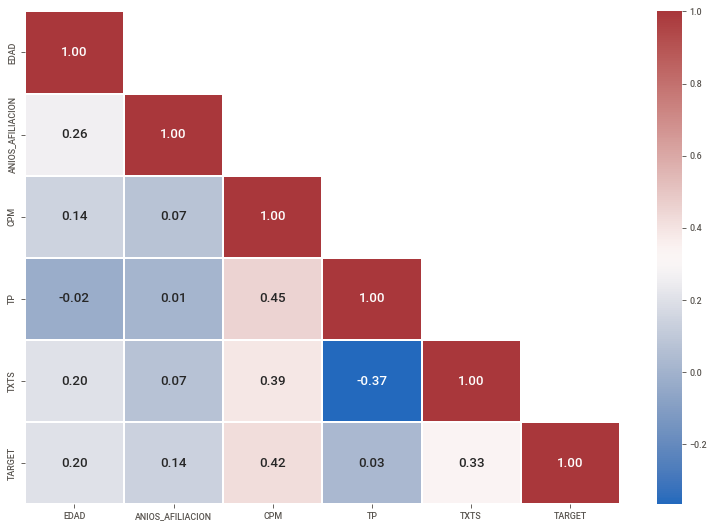

In [11]:
df = data.drop('CLIENTE', axis=1)
#Calculo de Correlación
corr = df.corr(method='pearson')

#Creamos una mascara para ver la correlación en un solo lado
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask,1)]=True

#Plot the heatmap correlation
plt.figure(figsize=(12,8),dpi=80)
sns.heatmap(corr, mask=mask, annot=True, cmap = 'vlag', fmt='.2f', linewidths=0.2)
plt.show()

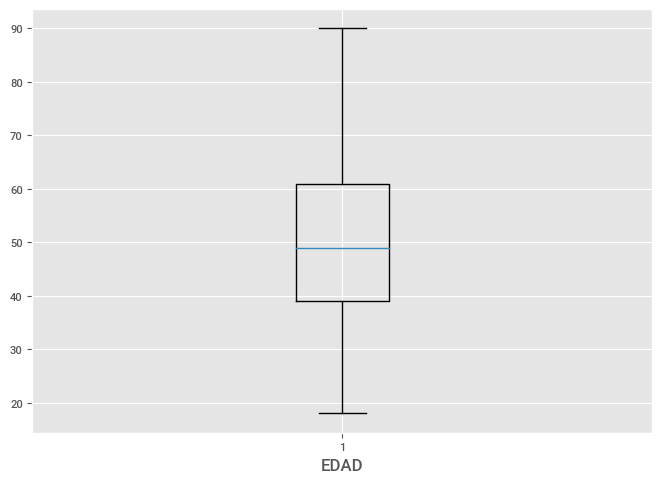

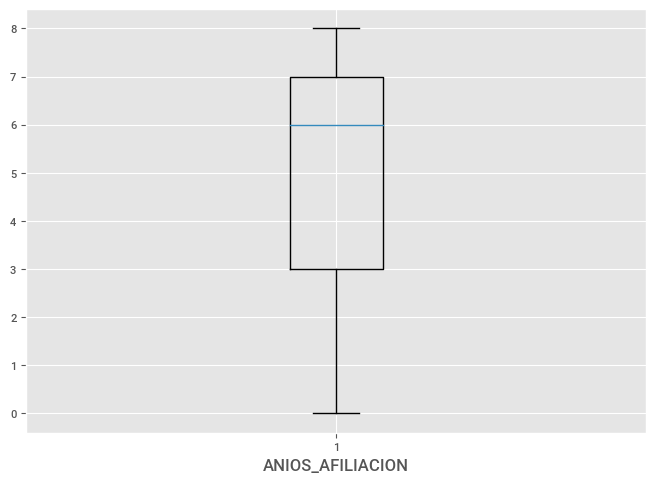

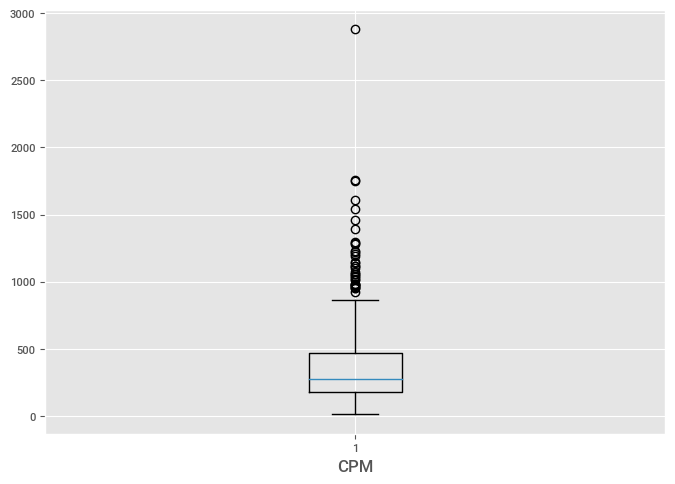

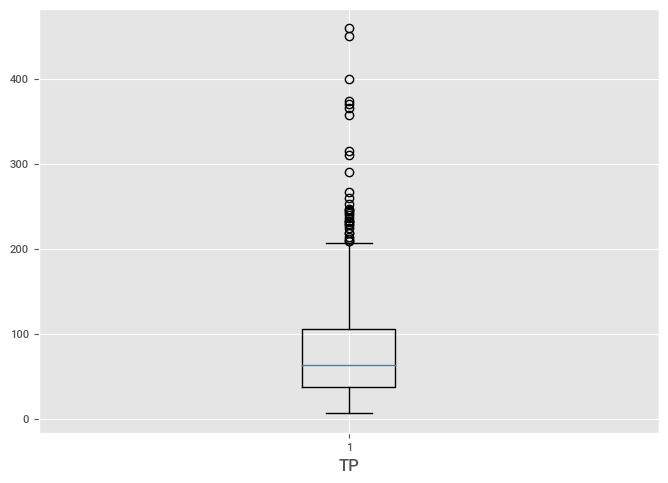

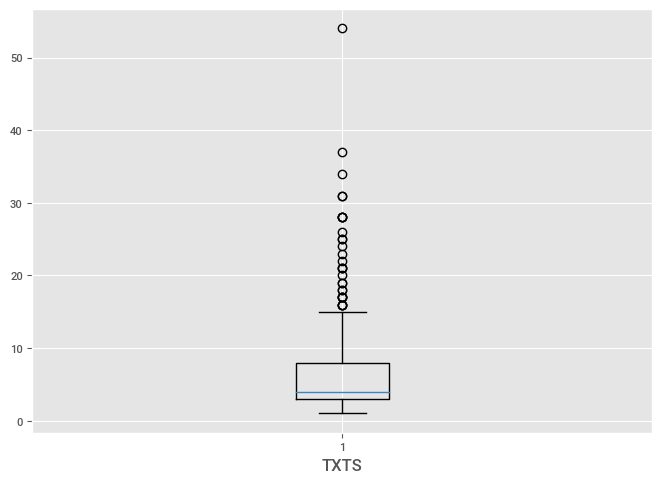

In [12]:
plt.style.use('ggplot')

for i in Num_Features:
    plt.boxplot(data[i])
    plt.xlabel(i)
    plt.show()

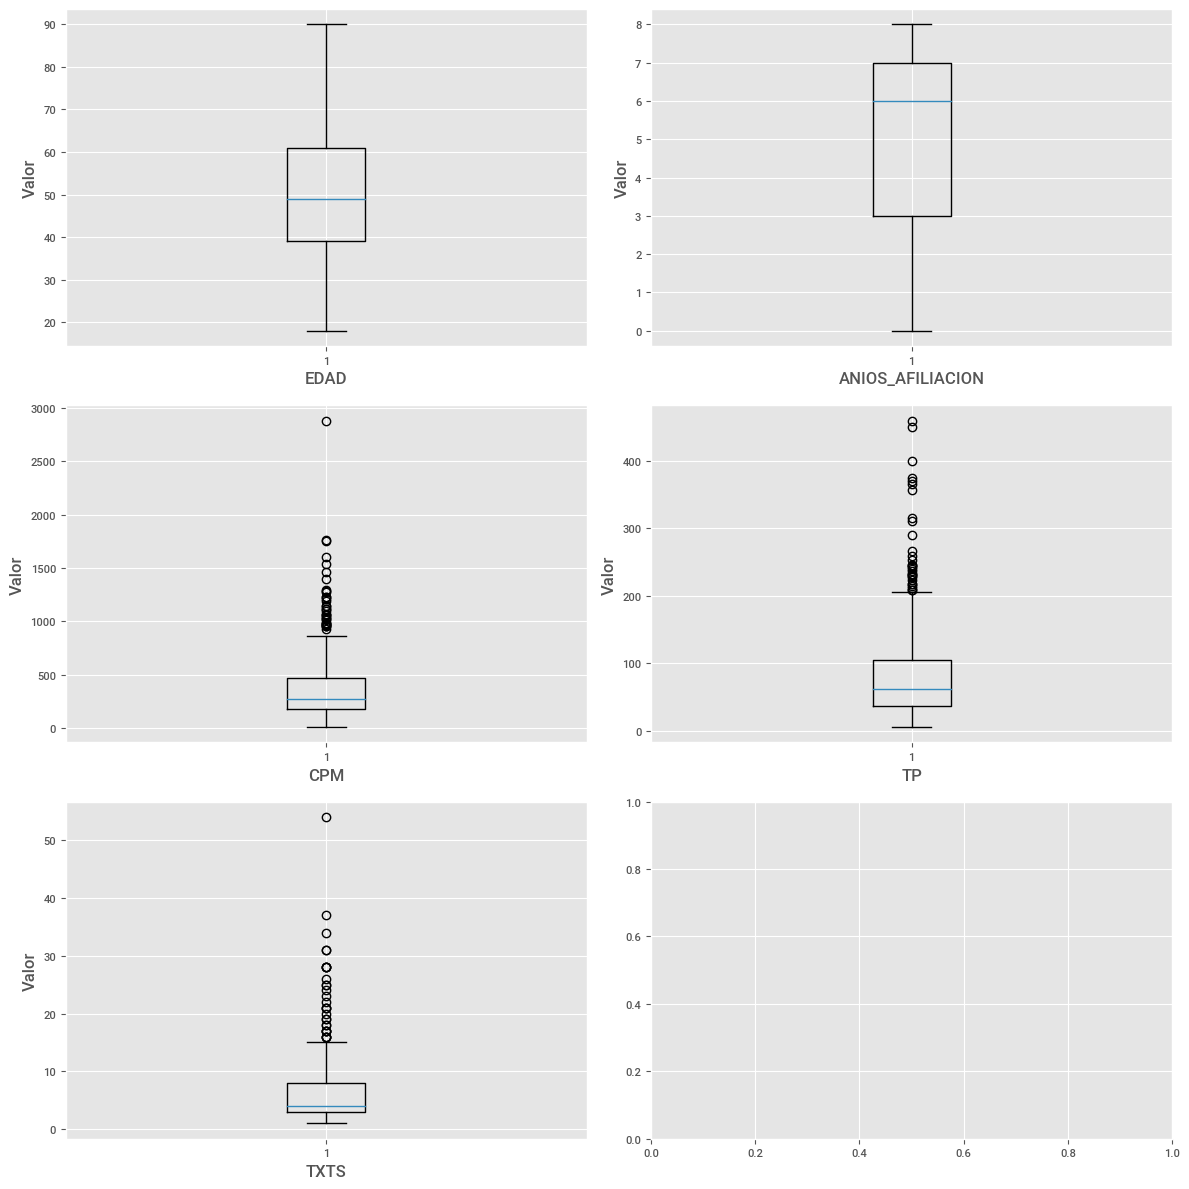

In [13]:
plt.style.use('ggplot')

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(12, 12))

for i, feature in enumerate(Num_Features):
    ax = axs[i // 2, i % 2]  # Obtener la subtrama actual correctamente
    ax.boxplot(data[feature])
    ax.set_xlabel(feature)
    ax.set_ylabel('Valor')
    #ax.set_title(feature)

plt.tight_layout()  # Ajustar el espaciado entre subtramas
plt.show()


Calculamos el coeficiente de asimetría y coeficiente de variación

In [14]:
from scipy import stats 
import pandas as pd


data_ca = {'Variable' : Num_Features,
       'Coeficiente_Asim' : stats.skew(data[Num_Features])}
asim = pd.DataFrame(data_ca)
asim

,Variable,Coeficiente_Asim
0,EDAD,0.299534
1,ANIOS_AFILIACION,-0.517769
2,CPM,2.587872
3,TP,2.075812
4,TXTS,2.758936


In [15]:
res_data_num = data[Num_Features].describe().transpose()
res_data_num['cv'] = res_data_num.iloc[:,2] / res_data_num.iloc[:,1] * 100
res_data_num

,count,mean,std,min,25%,50%,75%,max,cv
EDAD,500.0,50.442,14.436046,18.0,39.0,49.0,61.00,90.0,28.619100
ANIOS_AFILIACION,500.0,5.248,2.450818,0.0,3.0,6.0,7.00,8.0,46.700039
CPM,500.0,368.688,306.928730,11.0,177.0,275.5,471.25,2879.0,83.248907
TP,500.0,82.864,68.653070,6.0,37.0,63.0,105.00,459.0,82.850297
TXTS,500.0,6.286,5.990658,1.0,3.0,4.0,8.00,54.0,95.301586


In [16]:
np.seterr(divide = 'ignore', invalid = 'ignore')
s = setup(data,
          target = 'TARGET',
          imputation_type = 'iterative',
          n_jobs=-1,
          remove_outliers = True,
          ignore_features = ['CLIENTE'],
          session_id = 123)

,Description,Value
0,Session id,123
1,Target,TARGET
2,Target type,Binary
3,Original data shape,"(500, 10)"
4,Transformed data shape,"(482, 14)"
5,Transformed train set shape,"(332, 14)"
6,Transformed test set shape,"(150, 14)"
7,Ignore features,1
8,Ordinal features,1
9,Numeric features,5


In [17]:
(get_config('y_train').value_counts())/len(get_config('y_train')) *100

0    66.285714
1    33.714286
Name: TARGET, dtype: float64

In [18]:
models()

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


In [19]:
%%time

best = compare_models(sort='f1',
                      fold=10,
                      include=['dt','rf','lr'],
                      n_select = 3)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7657,0.7746,0.5182,0.7123,0.5968,0.4382,0.4510,0.4050
rf,Random Forest Classifier,0.7114,0.7297,0.4758,0.5902,0.5232,0.3211,0.3267,1.2850
dt,Decision Tree Classifier,0.6200,0.5866,0.4841,0.4479,0.4575,0.1690,0.1725,1.1360


Processing:   0%|          | 0/19 [00:00<?, ?it/s]

CPU times: user 4.01 s, sys: 251 ms, total: 4.26 s
Wall time: 31.8 s
